In [42]:
import numpy as np
import scipy as sp
from scipy import signal
from factor import *
from factor_graph import *

# Belief Propagation

___
$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}$

The joint probability distribution of a factor graph of $N$ variables with $M$ functions can be found as follows:
$$P(x_1, ...,x_n) = Z^{-1} \prod_{k=1}^{M} \psi_k(x_k)$$

Denote $\psi(j,i)$ as the factor between two adjacent nodes.

The Sum-Product Massage Passing is represeted as follows:

$$m_{i \to j}^t (i) = \sum_{j} \psi (j,i) \prod_{k \in \mc{N}(i) ∖ j} m_{k \to i}^t(k) $$

## Factor Product and Distributions

A factor object is represented with variable name and a numpy array-like distributions. E.g. $P(b)$

In [17]:
P = factor(['b'], np.array([0.3,0.7]))
P.get_distribution()

array([0.3, 0.7])

In [2]:
def factor_product(x, y):
    if x.is_none() or y.is_none():
        raise Exception('One of the factors is None')
    
    xy, xy_in_x_ind, xy_in_y_ind = np.intersect1d(x.get_variables(), y.get_variables(), return_indices=True)
    
    if xy.size == 0:
        raise Exception('Factors do not have common variables')
    
    if not np.all(x.get_shape()[xy_in_x_ind] == y.get_shape()[xy_in_y_ind]):
        raise Exception('Common variables have different order')
    
    x_not_in_y = np.setdiff1d(x.get_variables(), y.get_variables(), assume_unique=True)
    y_not_in_x = np.setdiff1d(y.get_variables(), x.get_variables(), assume_unique=True)
    
    x_mask = np.isin(x.get_variables(), xy, invert=True)
    y_mask = np.isin(y.get_variables(), xy, invert=True)
    
    x_ind = np.array([-1]*len(x.get_variables()), dtype=int)
    y_ind = np.array([-1]*len(y.get_variables()), dtype=int)
    
    x_ind[x_mask] = np.arange(np.sum(x_mask))
    y_ind[y_mask] = np.arange(np.sum(y_mask)) + np.sum(np.invert(y_mask))
    
    x_ind[xy_in_x_ind] = np.arange(len(xy)) + np.sum(x_mask)
    y_ind[xy_in_y_ind] = np.arange(len(xy))
    
    x_distribution = np.moveaxis(x.get_distribution(), range(len(x_ind)), x_ind)
    y_distribution = np.moveaxis(y.get_distribution(), range(len(y_ind)), y_ind)
                
    res_distribution =   x_distribution[tuple([slice(None)]*len(x.get_variables())+[None]*len(y_not_in_x))] \
                       * y_distribution[tuple([None]*len(x_not_in_y)+[slice(None)])]
    
    return factor(list(x_not_in_y)+list(xy)+list(y_not_in_x), res_distribution)

Consider the formula $P(a,b) = P(a \mid b)P(b)$

In [7]:
phi_1 = factor(['a','b'], np.array([[0.3,0.8],[0.2,0.1],[0.5,0.1]]))
phi_2 = factor(['b'], np.array([0.3,0.7]))
phi_3 = factor_product(phi_1, phi_2)
phi_3.get_distribution()

array([[0.09, 0.56],
       [0.06, 0.07],
       [0.15, 0.07]])

Compute the marginalization of a given joint distribution.

In [8]:
def factor_marginalization(x, variables):
    variables = np.array(variables)
    
    if x.is_none():
        raise Exception('Factor is None')
    
    if not np.all(np.in1d(variables, x.get_variables())):
        raise Exception('Factor do not contain given variables')
    
    res_variables    = np.setdiff1d(x.get_variables(), variables, assume_unique=True)
    res_distribution = np.sum(x.get_distribution(),
                              tuple(np.where(np.isin(x.get_variables(), variables))[0]))
    
    return factor(res_variables, res_distribution)

In [15]:
phi_4 = factor_marginalization(phi_3,['a'])
phi_4.get_distribution()

array([0.3, 0.7])

## Factor Graph

In [44]:
pgm = factor_graph()
pgm.add_factor_node('p12', factor(['x1','x2']))
pgm.add_factor_node('p32', factor(['x2','x3']))
pgm.add_factor_node('p24', factor(['x2','x4']))
print(pgm)

NameError: name 'factor' is not defined

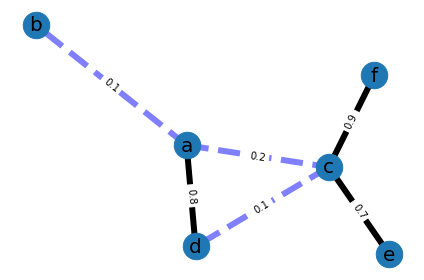

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

G.add_edge("a", "b", weight=0.1)
G.add_edge("a", "c", weight=0.2)
G.add_edge("c", "d", weight=0.1)
G.add_edge("c", "e", weight=0.7)
G.add_edge("c", "f", weight=0.9)
G.add_edge("a", "d", weight=0.8)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [23]:
data = np.random.randn(10000)
x = np.sort(data)
y = sp.stats.norm.cdf(x)


Text(0.5, 0, 'x')

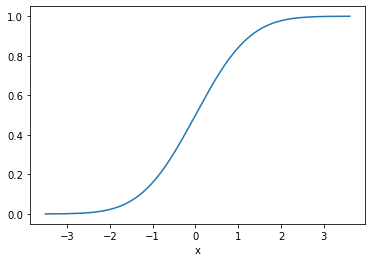

In [24]:
plt.plot(x,y)
plt.xlabel('x')

In [25]:
# Define the CDF and PDF of the exponential distribution
def expon_cdf(t, s=1):
    return 1 - math.exp(-1 / s * t)

def expon_pdf(t, s=1):
    return 1 / s * math.exp(-1 / s * t)

In [41]:
# Suppose the infected nodes have the attribute '1' and susceptible '0'
nodes = [("a", 1),("b", 1),("c", 1),("d", 0)]
boundary_nodes = [("c", 1),("d", 0)]
t = 1

def bp(t, boundary_nodes):
    m = 1
    for node in boundary_nodes:
        m = m * expon_cdf(t) if node[1] == 1 else m * (1 - expon_cdf(t))
        m_p = signal.fftconvolve(m,expon_pdf(t))
    return m_p
